<h1>1. Load Twitter Sentiment Data</h1>
<ul>
    <li>Load the twitter sentiment dataset, set the index, calculate engagement ratio and filter out stocks with no significant twitter activity. </li>
</ul>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os

# Set the plotting style to 'ggplot' for consistency in visualizations
plt.style.use('ggplot')

# Define the path to the folder containing the data files
data_folder = '/Users/codymckeon/Library/Mobile Documents/com~apple~CloudDocs/ml_projects/unsupervised/twitter_sentiment_strategy_engagement_ratio/data'

# Load the sentiment data from a CSV file into a DataFrame
# The CSV file is expected to contain at least 'date', 'symbol', 'twitterComments', and 'twitterLikes' columns
sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

# Convert the 'date' column to datetime format for accurate time-based operations
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Set the DataFrame's index to be a multi-index of 'date' and 'symbol'
# This allows for easy time-series analysis and grouping by stock symbol
sentiment_df = sentiment_df.set_index(['date', 'symbol'])

# Calculate the 'engagement_ratio' as the ratio of Twitter comments to Twitter likes
# This ratio can be an indicator of how actively engaged users are with content related to a stock
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

# Filter the DataFrame to include only rows where:
# - The number of Twitter likes is greater than 20
# - The number of Twitter comments is greater than 10
# This filtering removes data points with low engagement that may not be statistically significant
sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]



<h3>2. Aggregate Monthly and Calculate average sentiment for the month. </h3>
<ul>
    <li>Aggregate on a monthly level and calculate average monthly metric, for the one we choose. </li>
</ul>

In [11]:
# Reset the index to make 'symbol' a column, allowing us to group by both date and symbol
# Group the data by 'symbol' and time, aggregated at a monthly frequency ('ME')
# Calculate the mean engagement ratio for each symbol within each month
aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='ME'), 'symbol'])
[['engagement_ratio']].mean())

# Rank the symbols within each month based on their engagement ratio, in descending order
# This rank helps to identify the most engaged stocks per month
aggregated_df['rank'] = (aggregated_df.groupby(level=0)['engagement_ratio']
                        .transform(lambda x: x.rank(ascending=False)))

aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  42.0
           AAPL            0.256318  27.0
           ABBV            0.244677  29.0
           ABT                  inf   1.0
           AES             0.864613   3.0
...                             ...   ...
2023-01-31 TMO             0.182282  68.0
           TSLA            0.151992  75.0
           TSN             0.280553  31.0
           V               0.194045  65.0
           XOM             0.217904  55.0

[1118 rows x 2 columns]

<h3>3. Select Top 5 Stocks based on their cross-sectional ranking for each month</h3>
<ul>
    <li>Select top 5 stocks by rank for each month and fix the date to start at beginning for next month.</li>
</ul>

In [53]:
# Filter the DataFrame to keep only the top 5 symbols by engagement ratio per month
# This is done by selecting rows where the rank is less than 6
filtered_df= aggregated_df[aggregated_df['rank']<6].copy()

# Reset the index to move 'symbol' from the index back to a column
filtered_df = filtered_df.reset_index(level=1)

# Shift the date index forward by one day
# This is done to adjust the timing for further analysis, possibly to align with trading days
filtered_df.index = filtered_df.index +pd.DateOffset(1)

# Reset the index to make 'date' and 'symbol' regular columns, and then set them back as a multi-index
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])
filtered_df.head(20)


engagement_ratio  rank
date       symbol                        
2021-12-01 ABT                  inf   1.0
           AES             0.864613   3.0
           GILD            0.775439   4.0
           MNST            0.699721   5.0
           OXY             1.954273   2.0
2022-01-01 EA              1.081207   4.0
           ILMN            1.255583   3.0
           L               3.226812   1.0
           LUV             1.303215   2.0
           MA              0.883401   5.0
2022-02-01 AEP             0.693750   5.0
           AMD             0.715556   4.0
           D               0.911997   2.0
           LUV             1.035258   1.0
           MA              0.729063   3.0
2022-03-01 AAP                  inf   1.0
           AES             2.014844   2.0
           FCX             1.138332   4.0
           LUV             1.574377   3.0
           OXY             1.025579   5.0

<h3>4. Extract the stocks to form portfolios with at the start of each new month. </h3>
<ul>
    <li>Create a dictionary containing start of month and corresponded selected stocks.</li>
</ul>

In [54]:
# Extract the unique dates from the 'date' level of the multi-index in filtered_df
# Convert these dates into a list of unique date objects
dates = filtered_df.index.get_level_values('date').unique().tolist()

# Initialize an empty dictionary to store the fixed dates and associated symbols
fixed_dates = {}

# Convert the date to a string in the 'YYYY-MM-DD' format
    # Use .xs() to extract the sub-DataFrame corresponding to that specific date (level=0 refers to the 'date' level)
    # Get the list of stock symbols associated with that date
    # Store this list in the fixed_dates dictionary with the date string as the key
 # Iterate over the dates
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['ABT', 'AES', 'GILD', 'MNST', 'OXY'],
 '2022-01-01': ['EA', 'ILMN', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AEP', 'AMD', 'D', 'LUV', 'MA'],
 '2022-03-01': ['AAP', 'AES', 'FCX', 'LUV', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'J', 'PFE', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'HBAN', 'KEY'],
 '2022-06-01': ['AEP', 'AMD', 'HBAN', 'KEY', 'LMT'],
 '2022-07-01': ['AEP', 'AES', 'D', 'HBAN', 'J'],
 '2022-08-01': ['AEP', 'CB', 'D', 'J', 'JPM'],
 '2022-09-01': ['AEP', 'HON', 'L', 'META', 'MRNA'],
 '2022-10-01': ['AEP', 'KEY', 'META', 'NUE', 'STZ'],
 '2022-11-01': ['AEP', 'DD', 'ILMN', 'J', 'TSN'],
 '2022-12-01': ['AEP', 'AES', 'BKR', 'J', 'STZ'],
 '2023-01-01': ['AEP', 'BKR', 'ILMN', 'NCLH', 'NUE'],
 '2023-02-01': ['AEP', 'AES', 'BIIB', 'FCX', 'MDT']}

<h3>5. Download fresh stock prices for only selected/shortlisted stocks. </h3>

In [55]:
# Extract a unique list of stock symbols from the 'symbol' level of the multi-index in sentiment_df
# This list contains all the unique stock symbols that are present in the sentiment data
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist() 

# Use the yfinance library to download historical price data for the list of stock symbols
# The data is downloaded for the period from '2021-01-01' to '2023-03-01'
# The resulting DataFrame 'prices_df' will contain historical data (like Open, High, Low, Close, Volume) for each symbol
prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


<h3>6. Calculate Portfolio Returns with monthly rebalancing. </h3>

In [56]:
# Calculate the log returns of the 'Adj Close' prices from the prices_df DataFrame
# The logarithmic return is calculated as the difference in the natural logarithm of the adjusted close prices
returns_df = np.log(prices_df['Adj Close']).diff()

# Remove the first row from returns_df as it contains NaN values due to the diff() operation
returns_df = returns_df.iloc[1:]

# Initialize an empty DataFrame to store the portfolio returns over time
portfolio_df = pd.DataFrame() 

# Iterate over each start date in the fixed_dates dictionary
# fixed_dates maps each start date to a list of top-ranked stock symbols for that date
for start_date in fixed_dates.keys():
# Calculate the end date as the last day of the month for the given start date
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    # Retrieve the list of stock symbols corresponding to the current start date from fixed_dates
    cols = fixed_dates[start_date]

    # Calculate the average return of the selected stocks (columns) over the date range from start_date to end_date
    # The mean return is calculated across the selected stocks (cols) for each day in the range
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    # Concatenate the temporary DataFrame (temp_df) with the overall portfolio DataFrame (portfolio_df)
    # This is done vertically (axis=0) to build up the portfolio returns over time
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df


,portfolio_return
Date,
2021-12-01,-0.008139
2021-12-02,0.018316
2021-12-03,-0.001626
2021-12-06,0.017521
2021-12-07,0.018610
...,...
2023-02-22,-0.006059
2023-02-23,-0.009136
2023-02-24,-0.007268


<h3>7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy. </h3>

In [57]:
# Always use survivorship bias free stock list
# Download historical price data for the QQQ ETF (which tracks the NASDAQ-100 index)
# This ensures the use of a survivorship bias-free stock list, as QQQ represents the performance of the top 100 non-financial companies listed on NASDAQ
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

# Calculate the log returns for the QQQ ETF
# The logarithmic return is calculated as the difference in the natural logarithm of the adjusted close prices
qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

# Merge the NASDAQ return data (qqq_ret) with the portfolio returns (portfolio_df)
# The merge is performed on the index, which consists of date values
# The resulting DataFrame will contain both the portfolio returns and the NASDAQ (QQQ) returns for comparison
portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.008139,-0.017159
2021-12-02,0.018316,0.007181
2021-12-03,-0.001626,-0.017542
2021-12-06,0.017521,0.007981
2021-12-07,0.018610,0.029669
...,...,...
2023-02-22,-0.006059,0.000748
2023-02-23,-0.009136,0.008696
2023-02-24,-0.007268,-0.016886


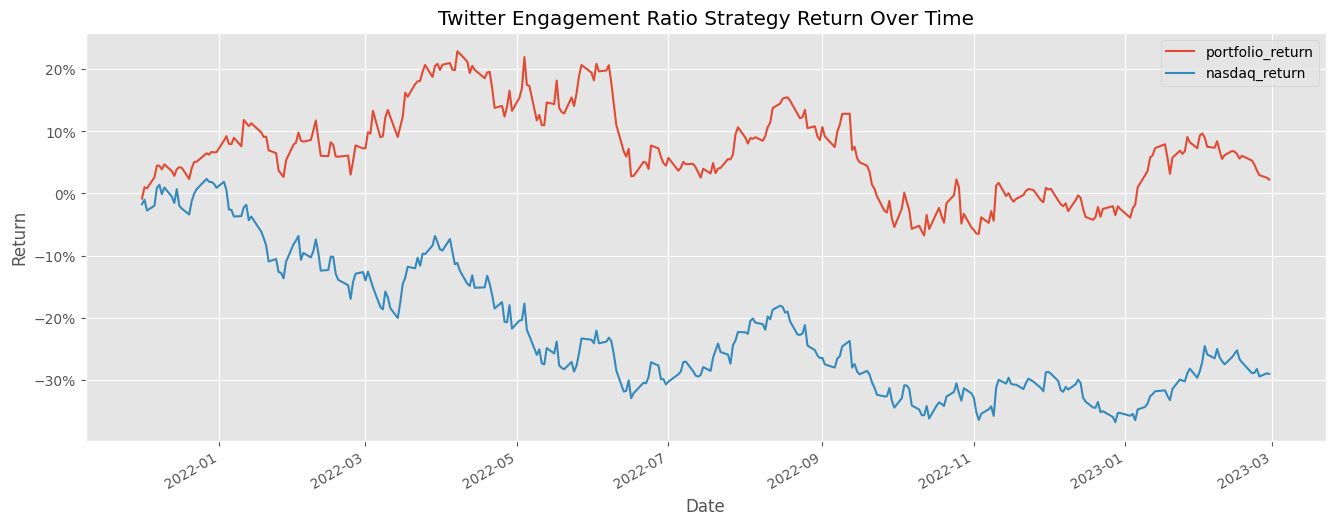

In [51]:
import matplotlib.ticker as mtick

# Calculate the cumulative return for both the portfolio and NASDAQ returns
# np.log1p(portfolio_df) calculates the natural logarithm of (1 + return) for each entry in the DataFrame
# .cumsum() calculates the cumulative sum of the log returns over time, effectively compounding the returns
# np.exp(...).sub(1) applies the exponential function to revert the log transformation and then subtracts 1 to get the actual cumulative return
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

# Plot the cumulative returns over time for both the portfolio and the NASDAQ index
# figsize=(16,6) sets the size of the plot
portfolio_cumulative_return.plot(figsize=(16,6))
plt.title('Twitter Engagement Ratio Strategy Return Over Time')

# Format the y-axis to display percentages
# mtick.PercentFormatter(1) formats the y-axis as a percentage with 1 being equal to 100%
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()